# Import Libraries for analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
import lightgbm as lgb


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'


# Import Databases

In [2]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [3]:
train.shape

(117959, 945)

In [4]:
#train.pivot_table(CITY, COVID_Status)

In [5]:
#Display all database


def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [6]:
display_all(train.describe())

DRIVERS       PASSPORT            LAT            LON  \
count  117959.000000  117959.000000  117959.000000  117959.000000   
mean        0.984935       0.981850      42.277738     -71.359432   
std         0.121810       0.133496       0.280501       0.596897   
min         0.000000       0.000000      41.241591     -73.490615   
25%         1.000000       1.000000      42.127746     -71.547992   
50%         1.000000       1.000000      42.317212     -71.154750   
75%         1.000000       1.000000      42.456261     -71.024435   
max         1.000000       1.000000      42.901078     -69.921561   

       HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE            Age  \
count         1.179590e+05         1.179590e+05  117959.000000   
mean          1.023666e+06         3.471099e+04      55.384600   
std           5.461491e+05         8.334722e+04      18.783242   
min           5.166400e+02         0.000000e+00       0.000000   
25%           6.093919e+05         5.097815e+03      40.000000   
50%           1.168081e+06         9.236690e+03      59.000000   
75%           1.467964e+06         1.819100e+04      71.000000   
max           3.203008e+06         1.557373e+06      84.000000   

       Allergy to bee venom  Allergy to dairy product  Allergy to eggs  \
count          10896.000000              10896.000000     10896.000000   
mean               0.172540                  0.038179         0.049284   
std                0.377867                  0.191637         0.216471   
min                0.000000                  0.000000         0.000000   
25%                0.000000                  0.000000         0.000000   
50%                0.000000                  0.000000         0.000000   
75%                0.000000                  0.000000         0.000000   
max                1.000000                  1.000000         1.000000   

       Allergy to fish  Allergy to grass pollen  Allergy to mould  \
count     10896.000000             10896.000000      10896.000000   
mean          0.167676                 0.254589          0.363803   
std           0.373596                 0.435650          0.481115   
min           0.000000                 0.000000          0.000000   
25%           0.000000                 0.000000          0.000000   
50%           0.000000                 0.000000          0.000000   
75%           0.000000                 1.000000          1.000000   
max           1.000000                 1.000000          1.000000   

       Allergy to nut  Allergy to peanuts  Allergy to soya  \
count    10896.000000        10896.000000     10896.000000   
mean         0.169787            0.188418         0.016887   
std          0.375463            0.391063         0.128854   
min          0.000000            0.000000         0.000000   
25%          0.000000            0.000000         0.000000   
50%          0.000000            0.000000         0.000000   
75%          0.000000            0.000000         0.000000   
max          1.000000            1.000000         1.000000   

       Allergy to tree pollen  Allergy to wheat  Dander (animal) allergy  \
count            10896.000000      10896.000000             10896.000000   
mean                 0.251836          0.045338                 0.334526   
std                  0.434087          0.208053                 0.471846   
min                  0.000000          0.000000                 0.000000   
25%                  0.000000          0.000000                 0.000000   
50%                  0.000000          0.000000                 0.000000   
75%                  1.000000          0.000000                 1.000000   
max                  1.000000          1.000000                 1.000000   

       House dust mite allergy  Latex allergy  Shellfish allergy  \
count             10896.000000   10896.000000        10896.00000   
mean                  0.248807       0.068741            0.32801   
std                   0.432342       0.253024            0.

In [7]:
#save oof
oof_df = train[["Id", "COVID_Status"]]

# Hyperparameters

In [8]:
seed = 42
#Using the parameters from ICU mortality 

param = {
            'learning_rate': 0.1, 
            'seed': 50,
            'objective':'binary',
            'boosting_type':'gbdt',
            'metric': 'auc',
        }  

In [9]:
train.drop(columns=['Death', 'Hospitalized', 'Ventilator', 'ICU', 
                    'Id', 'Days_hospitalized', 'Days_ICU', 'COVID_Status'], inplace=True)  

In [10]:
test.drop(columns=['Id'], inplace=True)

In [11]:
predictors_int = list(train.columns)

In [12]:
cat_names = ['DRIVERS' , 'PASSPORT', 'MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [13]:
predictors_int.remove('DRIVERS')
predictors_int.remove('PASSPORT')
predictors_int.remove('MARITAL')
predictors_int.remove('RACE')
predictors_int.remove('ETHNICITY')
predictors_int.remove('GENDER')
predictors_int.remove('COUNTY')
predictors_int.remove('PLACE_BIRTH')


# Creation of Dummies and missing values handling

In [14]:
train['is_train'] = 1
test['is_train'] = 0
train_test= pd.concat([train,test], axis = 0, sort=False)
#train_test

In [15]:
print(train.shape)
test.shape

(117959, 938)


(29492, 938)

In [16]:
#one-hot encoding of categorical variables
train_test = pd.get_dummies(train_test, columns = cat_names, dummy_na=True)

In [17]:
predictors = list(train_test.columns)
#predictors.remove('encounter_id')
predictors.remove('is_train')

# Training Loop

In [18]:
train_test.describe()

LAT            LON  HEALTHCARE_EXPENSES  HEALTHCARE_COVERAGE  \
count  147451.000000  147451.000000         1.474510e+05         1.474510e+05   
mean       42.277843     -71.359709         1.024125e+06         3.481290e+04   
std         0.280354       0.597387         5.462107e+05         8.415728e+04   
min        41.241591     -73.490615         5.166400e+02         0.000000e+00   
25%        42.127734     -71.548384         6.091488e+05         5.099480e+03   
50%        42.317359     -71.154657         1.167824e+06         9.241530e+03   
75%        42.456725     -71.024271         1.468306e+06         1.820228e+04   
max        42.901078     -69.921561         3.203008e+06         1.595563e+06   

                 Age  Allergy to bee venom  Allergy to dairy product  \
count  147451.000000          13722.000000              13722.000000   
mean       55.374531              0.172497                  0.037750   
std        18.818082              0.377825                  0.190597   
min         0.000000              0.000000                  0.000000   
25%        40.000000              0.000000                  0.000000   
50%        59.000000              0.000000                  0.000000   
75%        71.000000              0.000000                  0.000000   
max        84.000000              1.000000                  1.000000   

       Allergy to eggs  Allergy to fish  Allergy to grass pollen  ...  \
count     13722.000000     13722.000000             13722.000000  ...   
mean          0.049701         0.167541                 0.257105  ...   
std           0.217335         0.373472                 0.437054  ...   
min           0.000000         0.000000                 0.000000  ...   
25%           0.000000         0.000000                 0.000000  ...   
50%           0.000000         0.000000                 0.000000  ...   
75%           0.000000         0.000000                 1.000000  ...   
max           1.000000         1.000000                 1.000000  ...   

       PLACE_BIRTH_PL  PLACE_BIRTH_PR  PLACE_BIRTH_PT  PLACE_BIRTH_RU  \
count   147451.000000   147451.000000   147451.000000   147451.000000   
mean         0.000922        0.010342        0.000692        0.002258   
std          0.030356        0.101171        0.026292        0.047469   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        0.000000        0.000000   
50%          0.000000        0.000000        0.000000        0.000000   
75%          0.000000        0.000000        0.000000        0.000000   
max          1.000000        1.000000        1.000000        1.000000   

       PLACE_BIRTH_SA  PLACE_BIRTH_SV  PLACE_BIRTH_US  PLACE_BIRTH_VE  \
count   147451.000000   147451.000000   147451.000000   147451.000000   
mean         0.000068        0.001892        0.907766        0.002096   
std          0.008235        0.043458        0.289357        0.045730   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        1.000000        0.000000   
50%          0.000000        0.000000        1.000000        0.000000   
75%          0.000000        0.000000        1.000000        0.000000   
max          1.000000        1.000000        1.000000        1.000000   

       PLACE_BIRTH_VN  PLACE_BIRTH_nan  
count   147451.000000         147451.0  
mean         0.004313              0.0  
std          0.065534              0.0  
min          0.000000              0.0  
25%          0.000000              0.0  
50%          0.000000              0.0  
75%          0.000000              0.0  
max          1.000000              0.0  

[8 rows x 999 columns]

In [19]:
from sklearn.model_selection import KFold
nfold = 5
target = 'is_train'
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train_test))
#predictions = np.zeros(len(test))

In [20]:

i = 1

for train_index, valid_index in skf.split(train_test, train_test.is_train.values):
    print("\nfold {}".format(i))
    
    #Train data
    t=train_test.iloc[train_index]
        
    xg_train = lgb.Dataset(t[predictors].values,
                           label=t[target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    xg_valid = lgb.Dataset(train_test.iloc[valid_index][predictors].values,
                           label=train_test.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    num_rounds = 50000
    clf = lgb.train(param, xg_train, num_rounds, valid_sets = [xg_train, xg_valid], 
                    verbose_eval=2000, early_stopping_rounds = 100)  #1000
    oof[valid_index] = clf.predict(train_test.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    #save models
    clf.save_model('lgb_classifier_fold{}.txt'.format(i), num_iteration=clf.best_iteration) 
    #to read model model = lgb.Booster(model_file='lgb_classifier.txt')
    #predictions += clf.predict(test, num_iteration=clf.best_iteration) / nfold
    i = i + 1



fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[37]	training's auc: 0.638344	valid_1's auc: 0.505684

fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[82]	training's auc: 0.705582	valid_1's auc: 0.501737

fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.521921	valid_1's auc: 0.506258

fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.537115	valid_1's auc: 0.507343

fold 5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.54599	valid_1's auc: 0.507181


In [21]:
print("\n\nCV AUC: {:<0.5f}".format(metrics.roc_auc_score(train_test.is_train.values.astype(bool), oof)))
print("\n\nCV log loss: {:<0.5f}".format(metrics.log_loss(train_test.is_train.values.astype(bool), oof)))
print("\n\nCV Gini: {:<0.5f}".format(2 * metrics.roc_auc_score(train_test.is_train.values.astype(bool), oof) -1))




CV AUC: 0.50305


CV log loss: 0.50083


CV Gini: 0.00610


In [22]:
print(metrics.classification_report(train_test.is_train.values.astype(bool), oof >0.5))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00     29492
        True       0.80      1.00      0.89    117959

    accuracy                           0.80    147451
   macro avg       0.40      0.50      0.44    147451
weighted avg       0.64      0.80      0.71    147451



In [23]:
print(metrics.classification_report(train_test.is_train.values.astype(bool), oof >0.1))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00     29492
        True       0.80      1.00      0.89    117959

    accuracy                           0.80    147451
   macro avg       0.40      0.50      0.44    147451
weighted avg       0.64      0.80      0.71    147451



/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
print(metrics.classification_report(train_test.is_train.values.astype(bool), oof >0.05))

/home/maria/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00     29492
        True       0.80      1.00      0.89    117959

    accuracy                           0.80    147451
   macro avg       0.40      0.50      0.44    147451
weighted avg       0.64      0.80      0.71    147451



# Explainability

In [25]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [26]:
fpr_rf, tpr_rf, _ = roc_curve(train_test.is_train.values.astype(bool), oof)

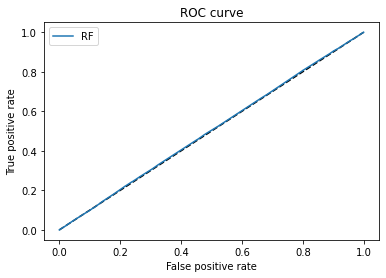

In [27]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [28]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(train_test.is_train.values.astype(bool), oof)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


Average precision-recall score: 0.80


In [29]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

In [30]:
#https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#simple-xgboost-classifier

In [31]:
import seaborn as sns

In [32]:
imp_df = pd.DataFrame()
imp_df['feature'] = predictors
imp_df['gain']  = clf.feature_importance(importance_type='gain')
imp_df['split'] = clf.feature_importance(importance_type='split')

In [33]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

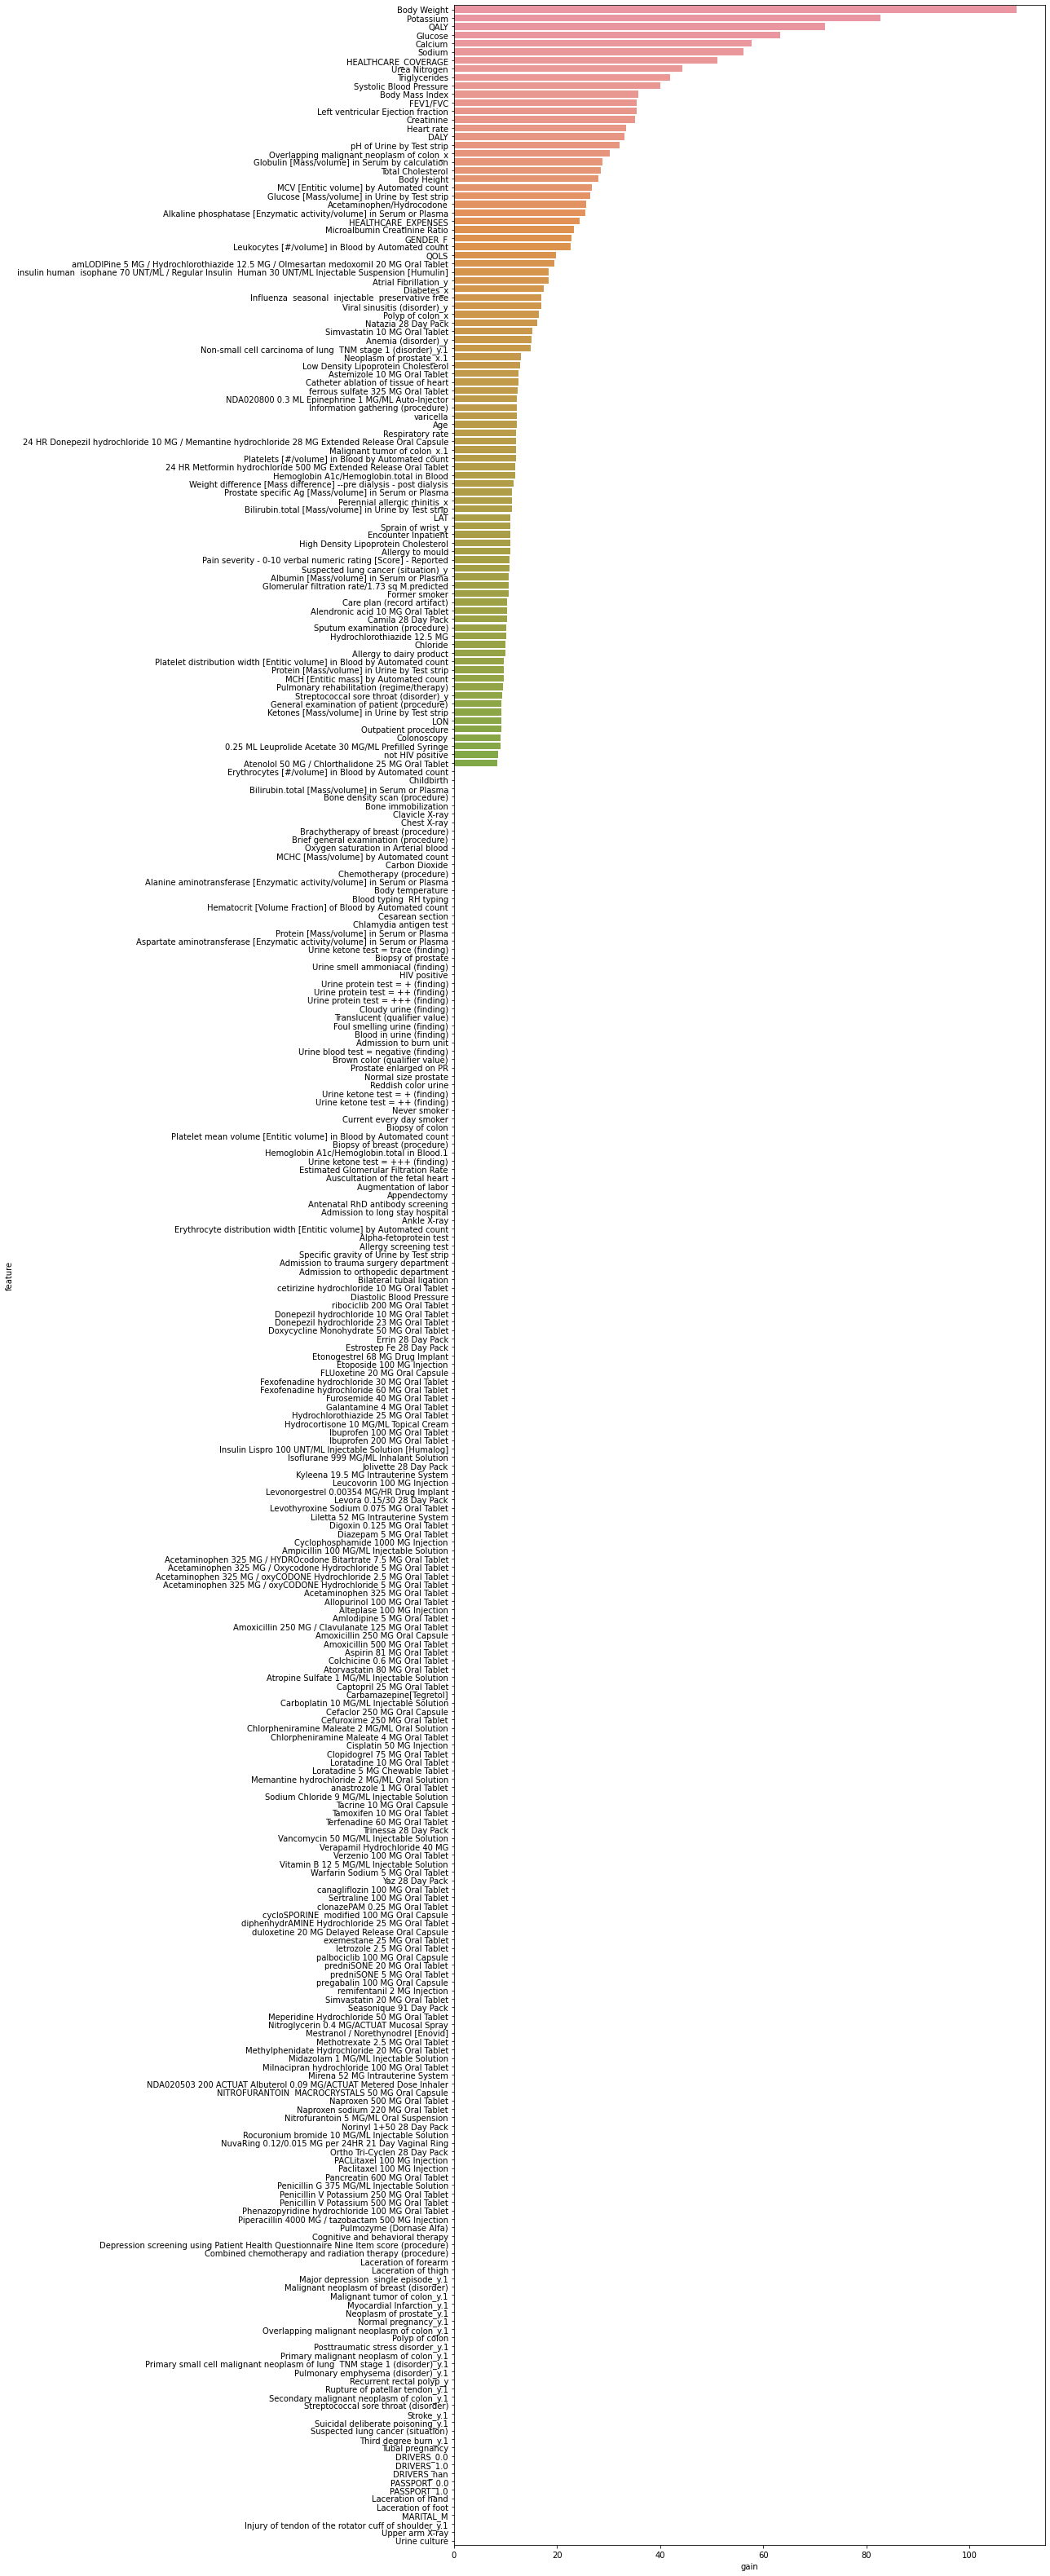

In [34]:
plot_importances(imp_df)